In [1]:
seed = 123
import sys
from pathlib import Path
from typing import *
import shutil
import time
import pandas as pd
import pickle
import torch
import numpy as np
import os
from torch.utils.data import random_split, Subset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, "..")
from dataset.data import (
    RNADataset,
    ROOT_DIR,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
    MAX_RNA_SIZE,
)

import haiku as hk
import jax
import jax.numpy as jnp
import nucleotide_transformer
from nucleotide_transformer.mypretrained import get_pretrained_model
import time
random_key = jax.random.PRNGKey(0)

In [13]:
pos_width_multipliers = {1000000: 0.5}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

In [14]:
rna_rna_files_dir = os.path.join(ROOT_DIR, "dataset", "rna_rna_pairs")
processed_files_dir = os.path.join(ROOT_DIR, "dataset", "processed_files")
nt_data_dir = os.path.join(processed_files_dir, "nt_data")
embedding_dir = os.path.join(nt_data_dir, "embeddings")
metadata_dir = os.path.join(nt_data_dir, "metadata")
nt_dir =  os.path.join(ROOT_DIR, "NT_dependencies")

In [15]:
set_data = 'training' 
assert set_data in ['training', 'val', 'test']

In [16]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"))
df = pd.read_csv(os.path.join(processed_files_dir, "final_df.csv"))
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

In [23]:
meta = {}
id_couple = 0
seed_everything(seed)
for policy in (
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
    EasyNegAugment(
        per_sample=1,
        width_windows=neg_width_windows,
        height_windows=neg_height_windows,
    ),
    HardPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
        min_width_overlap=0.3,
        min_height_overlap=0.3,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
    HardNegAugment(
        per_sample=1,
        width_windows=neg_width_windows,
        height_windows=neg_height_windows,
    ),
):
    start_time = time.time()

    dataset = RNADataset(
        gene2info=df_genes,
        interactions=df,
        subset_file=subset_file,
        augment_policies=[
            policy,
        ],
    )
    for i, sample in tqdm(enumerate(dataset)):
        # d = {
        #     'id_sample':id_couple,
        #     'couple':sample.couple_id,
        #     'gene1':sample.gene1,
        #     'gene2':sample.gene2,
        #     'x1':sample.bbox.x1,
        #     'x2':sample.bbox.x2,
        #     'y1':sample.bbox.y1,
        #     'y2':sample.bbox.y2,
        #     'interacting':sample.interacting,
        #     'policy':sample.policy,
        #     'cdna1':sample.gene1_info["cdna"][sample.bbox.x1:sample.bbox.x2],
        #     'cdna2':sample.gene2_info["cdna"][sample.bbox.y1:sample.bbox.y2],
        #     'seed_x1':sample.seed_interaction_bbox.x1,
        #     'seed_x2':sample.seed_interaction_bbox.x2,
        #     'seed_y1':sample.seed_interaction_bbox.y1,
        #     'seed_y2':sample.seed_interaction_bbox.y2,
        #     'protein_coding1':sample.gene1_info["protein_coding"],
        #     'protein_coding2':sample.gene2_info["protein_coding"],
        #     'original_length1':len(sample.gene1_info["cdna"]),
        #     'original_length2':len(sample.gene2_info["cdna"]),
        # }
        # meta[id_couple] = d
        id_couple += 1
            
        # if i == 21:
        #     break
        #print(sample.gene1, sample.gene2)
        continue
meta = pd.DataFrame.from_dict(meta, 'index')
#meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

0it [00:00, ?it/s]

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [18]:
m = meta[meta.policy.isin({'smartneg', 'easypos'})]
assert (m.seed_x1 >= m.x1).all()
assert (m.seed_y1 >= m.y1).all()
assert ((m.seed_x2) <= (m.x2)).all()
assert ((m.seed_y2) <= (m.y2)).all()

2118 3705
0.5716599190283401


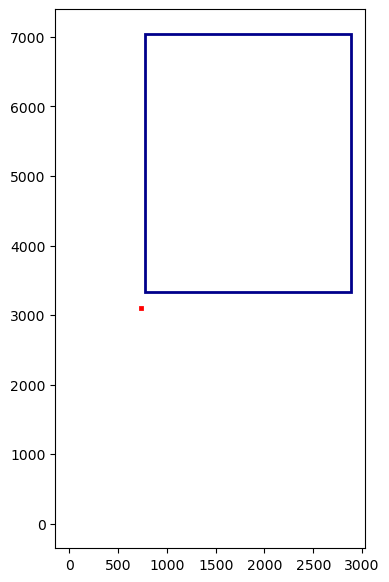

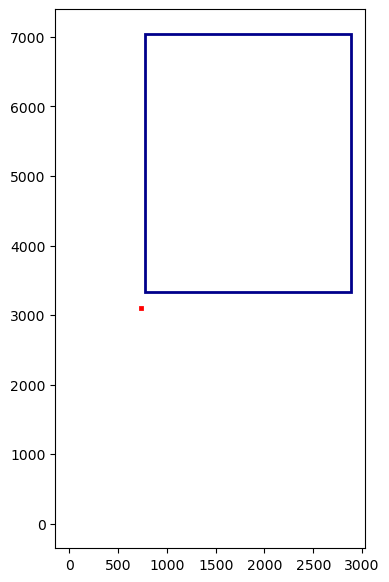

In [22]:
plot_sample(sample, True)

### NT Embeddings

In [5]:
def retrieve_embeddings(outs, tokens, layer):
    # Retrieve embeddings
    embeddings = outs[f"embeddings_{layer}"][:, 1:, :]  # removing CLS token
    padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
    masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
    sequences_lengths = jnp.sum(padding_mask, axis=1)
    mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths
    return mean_embeddings

def infer(sequences, forward_fn, tokenizer, parameters, random_key):
    tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
    tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
    tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)
    # Infer
    outs = forward_fn.apply(parameters, random_key, tokens)
    return outs, tokens

def save_data_to_folder(data, labels, ids, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for i in range(len(data)):
        sample = data[i]
        label = labels[i]
        id_sample = ids[i]
        if label == 0:
            class_folder = os.path.join(folder_path, 'class_0')
        else:
            class_folder = os.path.join(folder_path, 'class_1')
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        np.save(os.path.join(class_folder, f'{id_sample}.npy'), sample)

In [274]:
embeddings_layers_to_save = (20, 24, 28, 32)

model_name = '2B5_multi_species'

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    mixed_precision=False,
    embeddings_layers_to_save=embeddings_layers_to_save,
    attention_maps_to_save=(),
    max_positions=1000,
    chkpt_dir = os.path.join(nt_dir, 'checkpoints')
)
forward_fn = hk.transform(forward_fn)

In [330]:
sequences1 = [''.join(['A'for i in range(MAX_RNA_SIZE)]), ''.join(['A'for i in range(MAX_RNA_SIZE-20)]), ''.join(['C'for i in range(MAX_RNA_SIZE-5)]), 'TAAAAAAAAAAACC', 'TAAAACC']
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences1)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences1)]

In [331]:
layer = 20
outs, tokens = infer(sequences1, forward_fn, tokenizer, parameters, random_key)
embeddings = outs[f"embeddings_{layer}"][:, 1:, :]  # removing CLS token
padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1) # padding_mask.shape is (batch_size, 999, 1)
masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
# masked_embeddings.shape is (batch_size, 999, 2560)
sequences_lengths = jnp.sum(padding_mask, axis=1) #sequences_lengths.shape is (batch_size, 1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths #mean_embeddings.shape is (batch_size, 2560)

In [332]:
def calculate_grouped_mean_embeddings(outs, layer, tokens, tokenizer, k):
    # Get the embeddings for the specified layer
    embeddings = outs[f"embeddings_{layer}"]
    
    # Remove the CLS token and paddings
    embeddings = embeddings[:, 1:, :]
    padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
    masked_embeddings = embeddings * padding_mask
    
    # Calculate the number of groups
    batch_size = masked_embeddings.shape[0]
    seq_length = masked_embeddings.shape[1]
    num_groups = seq_length // k
    
    # Reshape the embeddings to form groups
    grouped_embeddings = jnp.reshape(masked_embeddings[:, :num_groups*k, :], (batch_size, num_groups, k, -1))
    grouped_padding_mask = jnp.reshape(padding_mask[:, :num_groups*k, :], (batch_size, num_groups, k, -1))
    
    # Calculate the mean embeddings for each group
    group_sum_embeddings = jnp.sum(grouped_embeddings, axis=2)
    sequence_count_in_groups = grouped_padding_mask.sum(axis=2)
    sequence_count_in_groups = jnp.where(sequence_count_in_groups == 0, 1, sequence_count_in_groups)  # to avoid division by zero
    group_mean_embeddings = group_sum_embeddings / sequence_count_in_groups
    
    return group_mean_embeddings

In [333]:
mean_embeddings_copy = calculate_grouped_mean_embeddings(outs, layer, tokens, tokenizer, k=999)

In [334]:
assert np.isclose(mean_embeddings, mean_embeddings_copy.squeeze()).all()

In [335]:
mean_embeddings2 = calculate_grouped_mean_embeddings(outs, layer, tokens, tokenizer, k=10)

In [336]:
(mean_embeddings2[0][0] - mean_embeddings2[1][0]).mean()

Array(0.00022485, dtype=float32)

In [337]:
(mean_embeddings2[0][0] - mean_embeddings2[2][0]).mean()

Array(0.05363286, dtype=float32)

In [338]:
(mean_embeddings2[2][0] - mean_embeddings2[3][0]).mean()

Array(-0.01238899, dtype=float32)

In [ ]:
batch_size = 12
n_batch = int(meta.shape[0]/batch_size)
slices = np.linspace(0, meta.shape[0], n_batch, dtype = np.int64)

In [ ]:
embeddings_layers_to_save = (20, 24, 28, 32)

model_name = '2B5_multi_species'

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    mixed_precision=False,
    embeddings_layers_to_save=embeddings_layers_to_save,
    attention_maps_to_save=(),
    max_positions=1000,
    chkpt_dir = os.path.join(nt_dir, 'checkpoints')
)
forward_fn = hk.transform(forward_fn)

In [ ]:
start_time = time.time()
for i in tqdm(range(len(slices)-1)):
    
    meta_slice = meta[slices[i]:slices[i+1]]
    labels = list(meta[slices[i]:slices[i+1]].interacting.values.astype(int))
    ids = list(meta[slices[i]:slices[i+1]].id_sample.values)
    
    sequences1 = list(meta_slice.cdna1.values)
    outs1, tokens1 = infer(sequences1, forward_fn, tokenizer, parameters, random_key)
    
    sequences2 = list(meta_slice.cdna2.values)
    outs2, tokens2 = infer(sequences2, forward_fn, tokenizer, parameters, random_key)
    
    for layer in embeddings_layers_to_save:
        layer_folder = os.path.join(embedding_dir, str(layer))
        if not os.path.exists(layer_folder):
            os.makedirs(layer_folder)
            
        mean_embeddings1 = retrieve_embeddings(outs1, tokens1, layer) #shape is (batch_size, 2560)
        mean_embeddings2 = retrieve_embeddings(outs2, tokens2, layer) #shape is (batch_size, 2560)
        
        #concatenate the two embeddings (check if I am doing this properly, with the rigth axis)
        embeddings = np.concatenate((mean_embeddings1, mean_embeddings2), axis=1) #shape is (2*batch_size, 5120)
        
        save_data_to_folder(embeddings, labels, ids,  os.path.join(layer_folder, set_data))
print(f"Total time to process batch: {(time.time()-start_time)/60} minutes")